# 4. Bank - Final Analysis

We have done the Exploratory Data Analysis [Here](1_Bank_EDA.ipynb), and have run our algorithms with base features [Here](2_Bank_ML.ipynb) and with feature engineering [Here](3_Bank_Features_Engineering.ipynb)

In this final notebook, we will focus on analyzing and comparing the results of these experiments. The goal is to evaluate how much feature engineering and data augmentation contributed to performance, identify the best-performing models, and understand their strengths and limitations. This analysis will help us draw clear conclusions about the modeling pipeline and guide the next steps.

In [1]:
import os, warnings, joblib, math
import numpy as np
import pandas as pd
from glob import glob
from sklearn import set_config
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")
set_config(transform_output="pandas") 

from bank_functions import *

In [2]:
result_folder = "Results"
final_dir = os.path.join(result_folder, "lgb", "final_models")

df_train = pd.read_csv("Data/train.csv")

target = "y"
X_cat = ["job","month","poutcome","education","contact","marital","loan","housing","default"]
X_num = ["balance","duration","pdays","age","campaign","previous","day"]

for col in X_cat:
    df_train[col] = df_train[col].astype('category')
    
X = df_train[X_cat + X_num]
y = df_train[target]

### 4.1 Impact of Feature Engineering

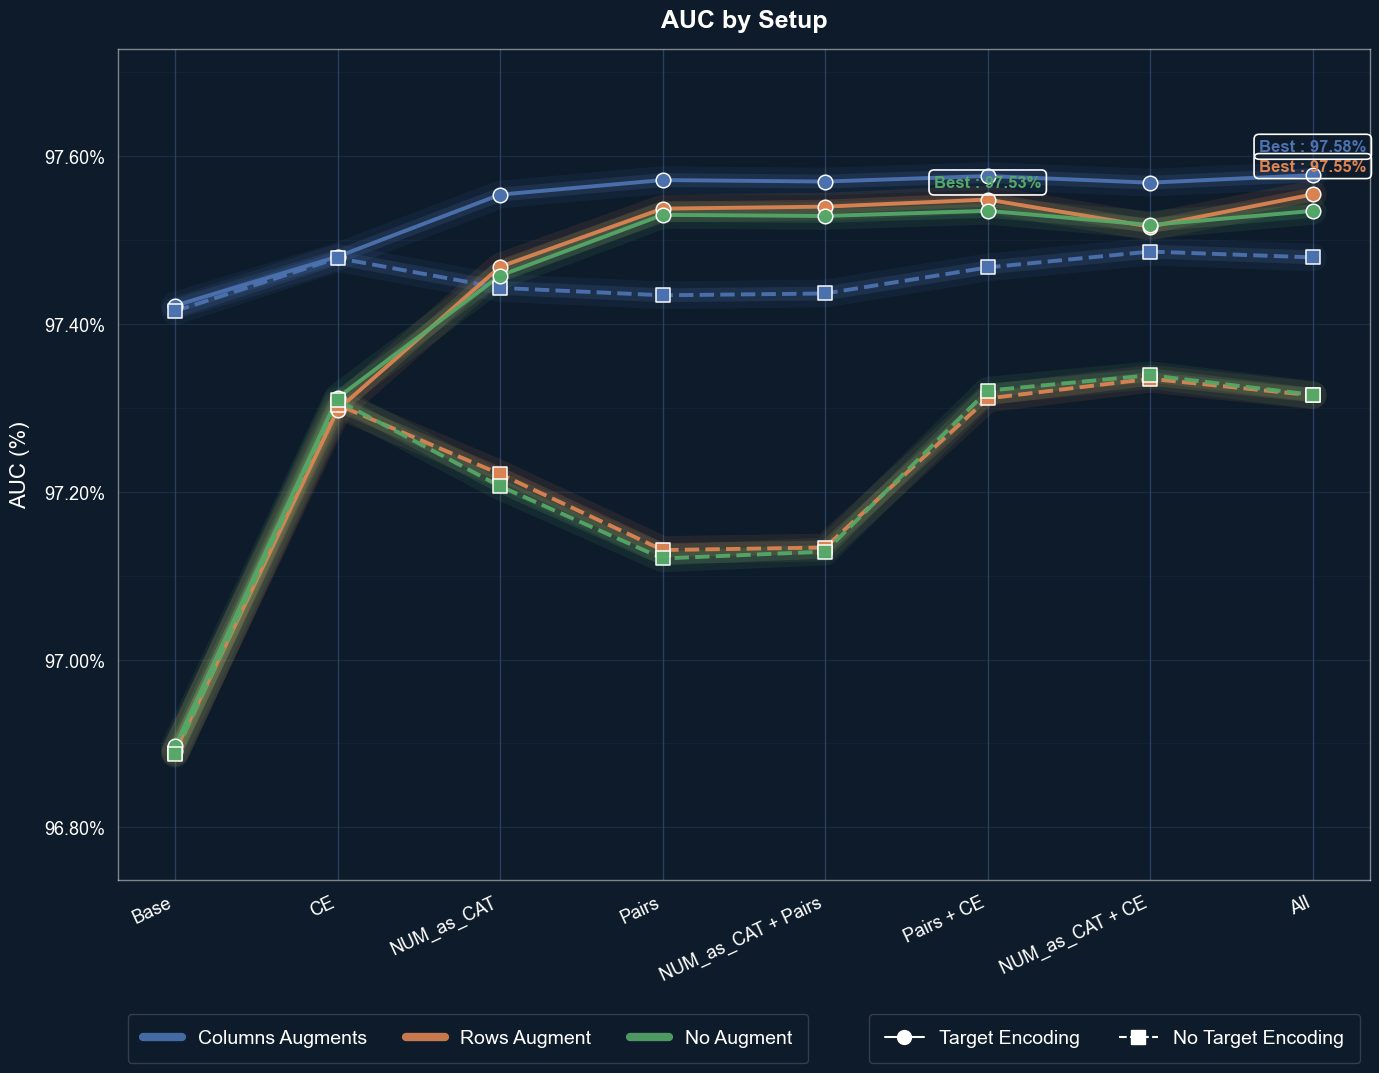

In [3]:
oof_dirs = glob(os.path.join(result_folder,"lgb","oof", "*"))
df_auc = pd.DataFrame({"setup":[os.path.basename(d).partition("_oof.")[0] for d in oof_dirs],
                       "auc":[roc_auc_score(y,pd.read_csv(file)) for file in oof_dirs]})

parsed = df_auc["setup"].apply(parse_setup)
df_auc["pass_variant"] = parsed.apply(lambda x: x[0])
df_auc["te"] = parsed.apply(lambda x: x[1])
df_auc["setup"] = parsed.apply(lambda x: x[2])

# --- mapping from raw category -> pretty label ---
label_map = {
    "base": "Base",
    "with_ce": "CE",
    "with_num_as_cat": "NUM_as_CAT",
    "with_pairs": "Pairs",
    "with_num_as_cat_and_pairs": "NUM_as_CAT + Pairs",
    "with_pairs_and_ce": "Pairs + CE",
    "with_num_as_cat_and_ce": "NUM_as_CAT + CE",
    "with_all": "All",
}
custom_order = list(label_map.keys())
df_auc["setup"] = pd.Categorical(df_auc["setup"], categories=custom_order, ordered=True)
    
plot_auc_by_series(df_auc, label_map = label_map)

From the plot above, we can learn a few patterns:
- Target encoding adds little on top of the base or CE-only setups, but it lifts AUC once we introduce categorical twins and pairs, with gains around +0.10% to +0.40% of AUC points.
- Row augmentation brings marginal change relative to the no-augment runs, while column augmentation consistently outperforms its counterparts across setups.
- The strongest results almost always occur when we combine all engineered features together (twins, pairs, count encoding, and OOF feature encoding).

### 4.2 Comparing all models

We are now going to compare the AUC across all the models we have trained so far. To make this comparison reliable, we will look at two complementary sources: the official leaderboard scores from Kaggle and the cross-validation AUC that we computed manually on the out-of-fold predictions. This way, we can assess not only how well each model generalizes to the hidden test set but also how stable and consistent its performance is across the folds of our training data.

In [4]:
base_oof = pd.read_csv(os.path.join(result_folder, "cv_oof.csv"))
augments = ["row","col"]
df_lgb_fe = pd.DataFrame({
    f"fe_lgb_{aug}": pd.read_csv(f).squeeze("columns")
    for aug in augments
    for f in [os.path.join(result_folder, "lgb", "oof", f"orig{aug}_with_all_te_oof.csv")]
})
df_lgb_fe["fe_blend"] = pd.read_csv(os.path.join(final_dir, "fe_blend_oof.csv"))
df_lgb_fe["fe_stack"] = pd.read_csv(os.path.join(final_dir, "fe_stack_oof.csv"))
df_oof = pd.concat([base_oof,df_lgb_fe],axis = 1)

In [5]:
kaggle_path = os.path.join(result_folder, f"kaggle_score.csv")
overwrite_ = False
load_dotenv() 

kaggle_perfs = get_kaggle_results(
    user = os.getenv("KAGGLE_USER"), 
    key = os.getenv("KAGGLE_KEY"), 
    path = kaggle_path,
    overwrite = overwrite_, 
    comp = "playground-series-s5e8", 
    models_names = df_oof.columns
)
df_score = compute_all_scores(df_oof, y = df_train[target])
df_score = df_score.join(kaggle_perfs, how = "outer") 

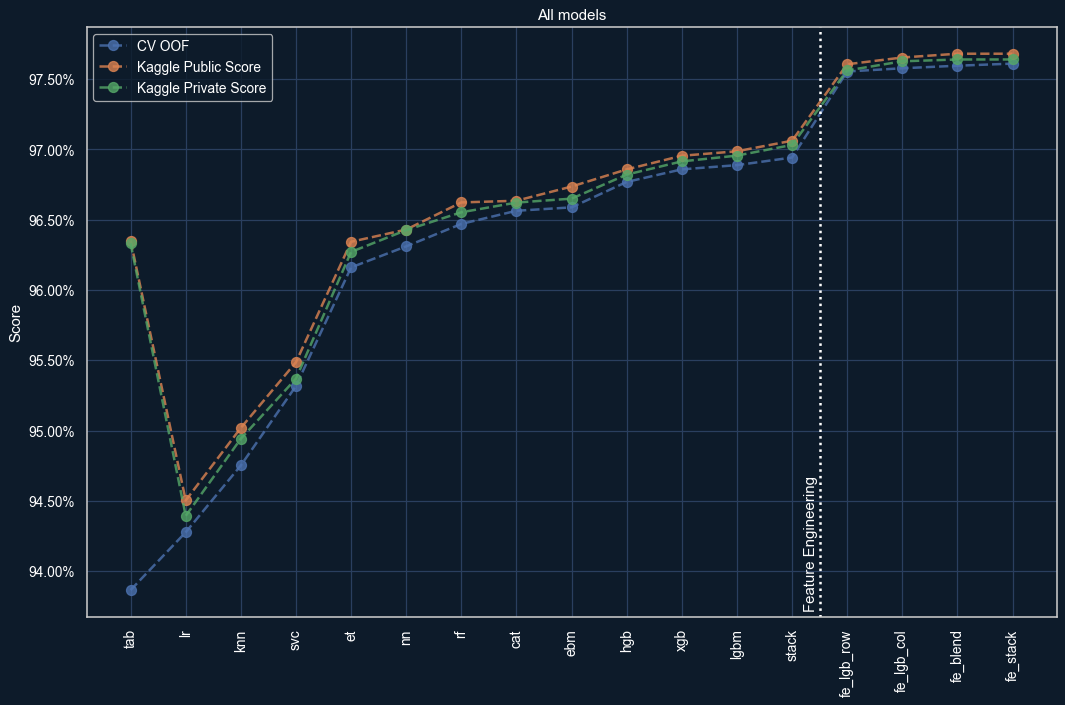

In [6]:
plot_scores(df_score,["roc_auc","publicScore","privateScore"],
            sort_by='roc_auc', ascending=True, title="All models",
            vline=len(base_oof.columns) - 0.5, vlabel="Feature Engineering",
            legend_names=["CV OOF","Kaggle Public Score","Kaggle Private Score"])

We can see that for almost all models (except TabNet), the AUC from cross-validation on out-of-fold predictions is strongly correlated with both Kaggle public and private scores. This is a very positive outcome, showing that our validation strategy was reliable and that the models generalized well: the performance observed during training carried over to the unseen test set, suggesting we did not overfit.

Another clear pattern is that all models with feature engineering significantly outperformed the baseline models trained on raw features. The models we enhanced with either additional data or engineered features were already strong individually, but their performance improved even further when combined. Blending these models or including them in a final stacking classifier consistently pushed the results higher, showing the value of leveraging complementary strengths.

lgbm: {'lgbm__class_weight': None}
rf: {'rf__class_weight': 'balanced'}
et: {'et__class_weight': None}
lr: {'lr__class_weight': 'balanced'}


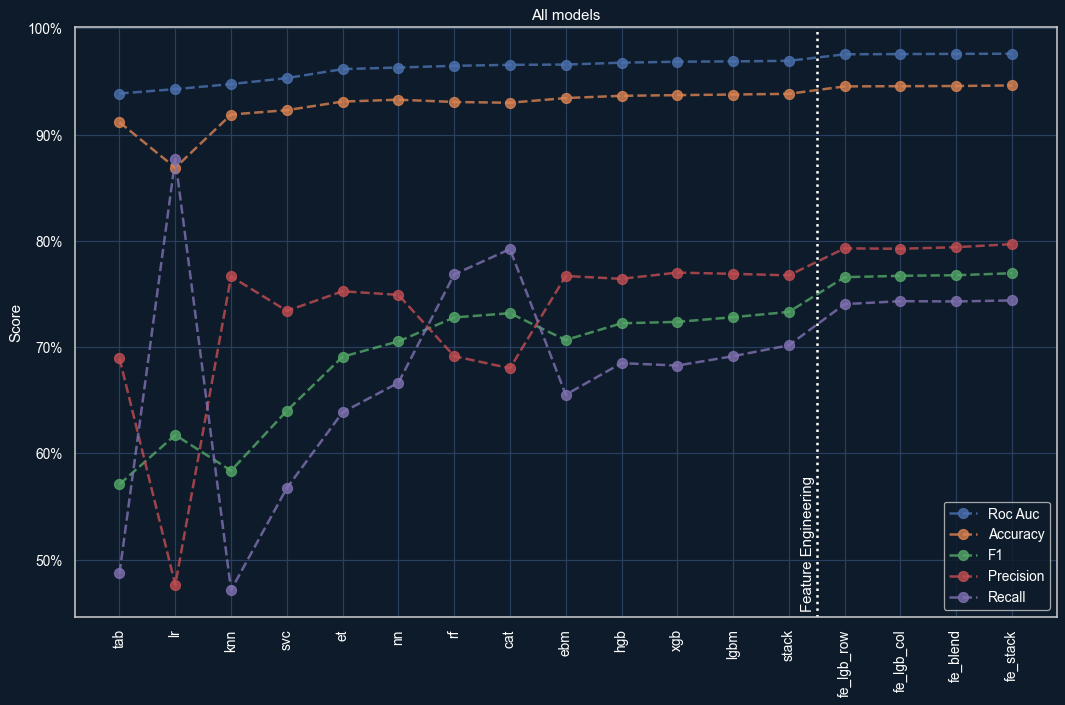

In [7]:
plot_scores(df_score, ["roc_auc","accuracy","f1","precision","recall"], 
            sort_by='roc_auc', ascending=True, title="All models",
            vline=len(base_oof.columns) - 0.5, vlabel="Feature Engineering")

models = {}
for model_name in base_oof.columns[:-1]:
    model = joblib.load(os.path.join(result_folder,"models", f"models_{model_name}.joblib"))
    models[model_name] = model
    found = {k: v for k, v in model.best_params_.items() if "class_weight" in k}
    if found:
        print(f"{model_name}: {found}")

Most models reach high accuracy (above 91%, with the best ones exceeding 95%). This level of accuracy should be expected given the class imbalance in our dataset, where the positive class only accounts for about 12% of the samples (as we have seen in the [EDA](1_Bank_EDA.ipynb)). In such cases, accuracy alone can be misleading since a model can achieve a high score simply by predicting the majority class most of the time.

Looking at precision and recall gives us more insight. The models with recall higher than precision are Logistic Regression, Random Forest, and CatBoost. This behavior comes from the fact that their best-performing versions during grid search were trained with **class_weight = balanced**. By reweighting the minority class, these models put more emphasis on capturing positives, which naturally boosts recall at the expense of precision. In practice, this means they are more willing to flag potential positives, even if it leads to a higher rate of false alarms.

Blending and stacking on top of engineered features deliver the most consistent metrics. We are not only ranking examples well (AUC) but also converting those ranks into better hard classifications (precision/recall balance).

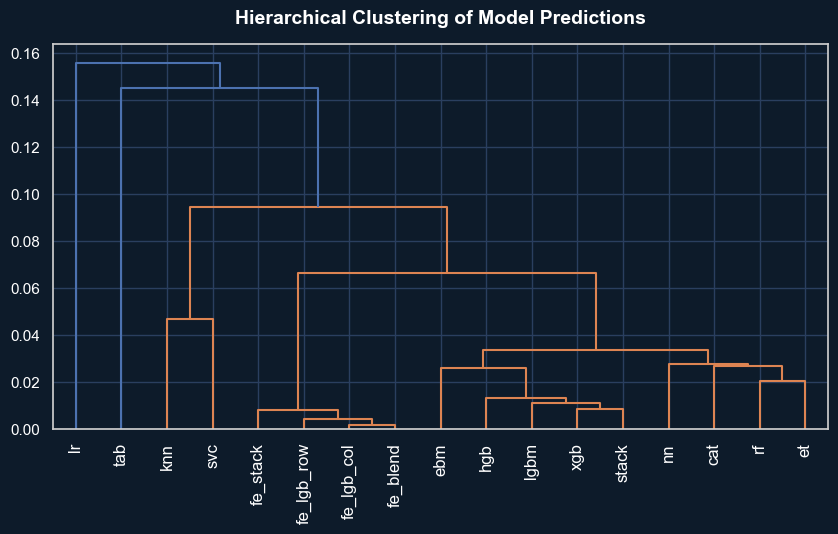

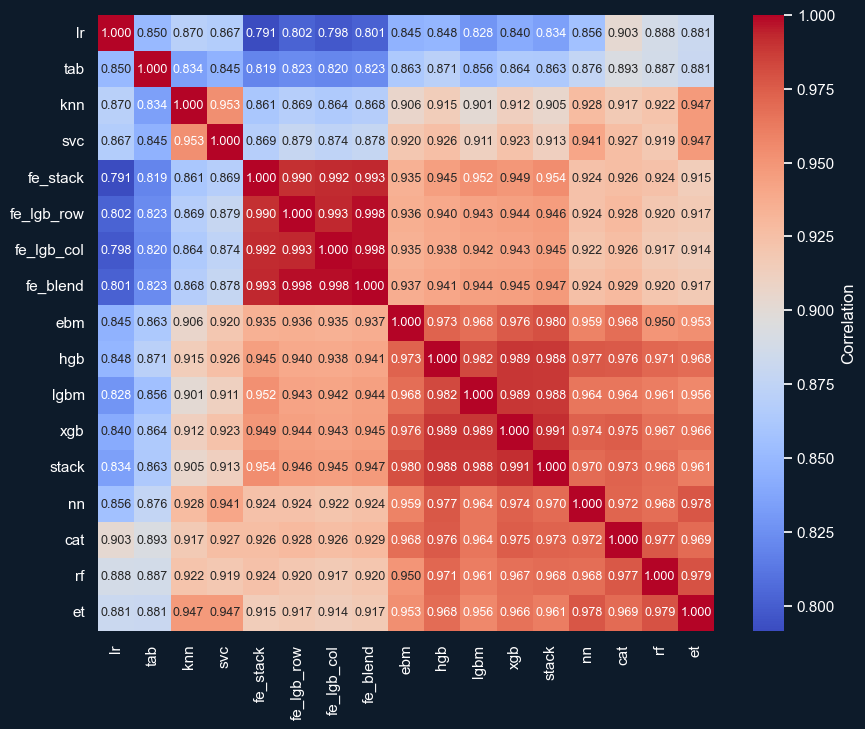

In [8]:
# correlation + linkage
corr_matrix     = df_oof.iloc[:, ].corr()
distance_matrix = 1 - corr_matrix
linkage_matrix  = linkage(squareform(distance_matrix), method='average')

# dendrogram 
orig_labels = corr_matrix.index            
plt.figure(figsize=(10, 5))
ddata = dendrogram(linkage_matrix,labels=orig_labels,orientation="top")          

ax = plt.gca()
ax.set_title("Hierarchical Clustering of Model Predictions", fontsize=14,weight="bold", pad=15)
plt.xticks(rotation=90)  
plt.show()

# heat-map figure (uses the same row_order)
row_order = ddata['leaves']       
clustered_corr = corr_matrix.iloc[row_order, :].iloc[:, row_order]
plt.figure(figsize=(10, 8))
sns.heatmap(clustered_corr,cmap="coolwarm",annot=True, fmt=".3f",annot_kws={"size": 9},
            cbar_kws={'label': 'Correlation'},square=True,linewidths=0, linecolor='none')
plt.show()

The plot above shows the correlation between the predicted values of all our models. As expected, the models with feature engineering are extremely correlated with one another (in the 99.2–99.8% range). This is logical since they are based on similar underlying features and differ mostly in how they are blended or stacked.

Among the base models, we see strong correlations within the boosting family (LightGBM, XGBoost, Histogram-Based GBM, and EBM). These models also correlate highly with the simple stack, which makes sense given that they consistently deliver the best standalone performances. In other words, their predictive patterns are very similar, so the stack is effectively combining highly aligned signals.

On the other hand, models like Logistic Regression, KNN, and TabNet sit further apart in the clustering. Their predictions are less correlated with the boosting group, which explains why they can still bring diversity into an ensemble even if their individual performance is weaker.

### 4.3 SHAP Analysis

In this chapter, we focus on variable importance using SHAP values applied to the feature engineering models. Since *fe_stack* is an ensemble stacking all models and *fe_blend* is only a weighted average of *fe_lgb_row* and *fe_lgb_col*, analyzing them directly would not add much interpretability. Instead, we will concentrate on *fe_lgb_row*, which combines feature engineering with data augmentation (the analysis on *fe_lgb_col* would be similar). 

This choice allows us to better understand which engineered variables are driving the predictions, while still reflecting the performance improvements we observed with the enhanced models.

We use SHAP because it provides both global and local interpretability. On the global side, it highlights which features consistently contribute the most across the dataset. On the local side, it explains individual predictions by showing how each feature pushes the output toward the positive or negative class. This dual perspective makes SHAP especially useful in our case, where we want not only strong performance but also a clear understanding of what drives the model’s decisions.

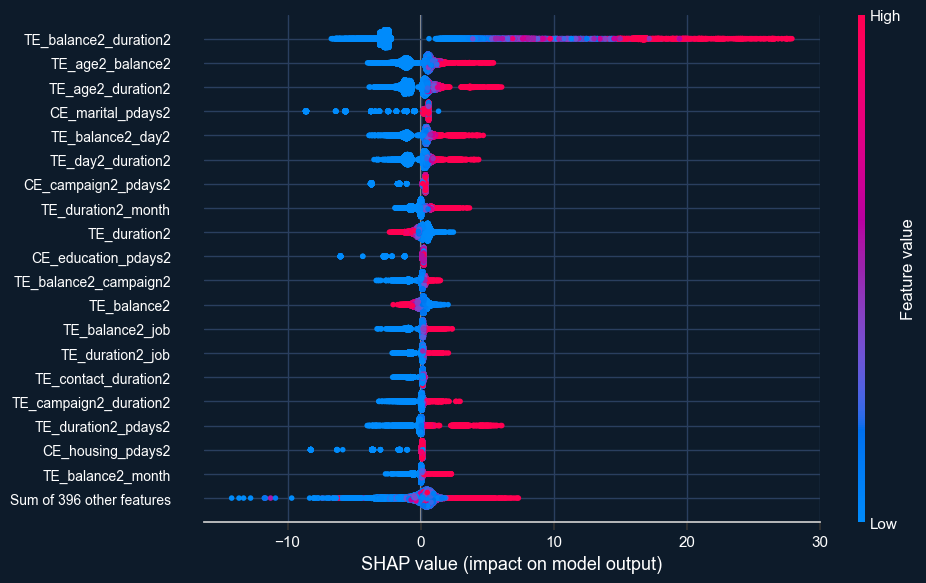

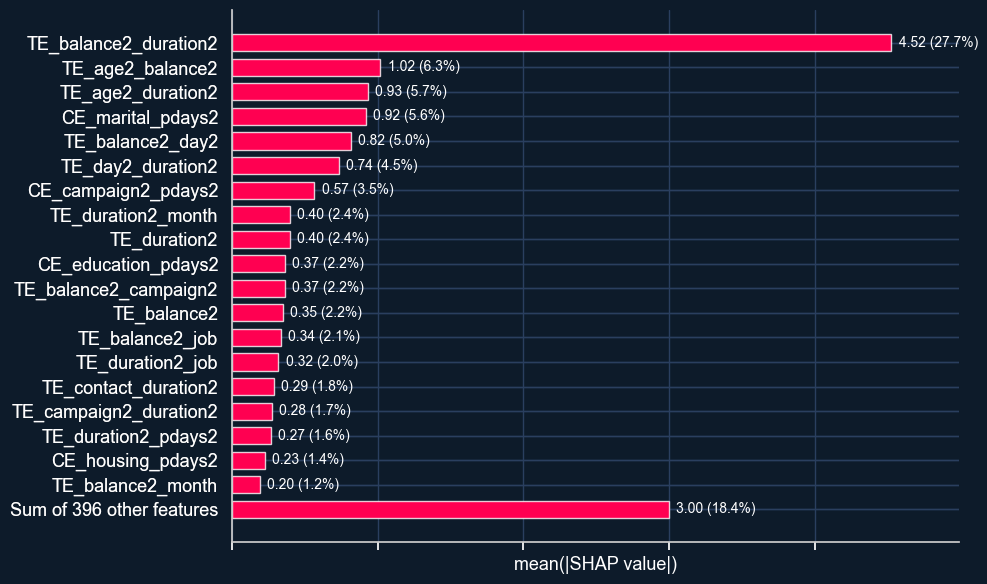

In [9]:
shap_folder = os.path.join(result_folder, "Shap")
sv = joblib.load(os.path.join(shap_folder, f"shap_origrow_with_all_te.joblib"))

shap.plots.beeswarm(sv, max_display=20, show=False)
fig = plt.gcf()
fig.set_size_inches(10, 6)    # enforce the size

ax = plt.gca()
ax.tick_params(axis='y', labelsize=10)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color("white")

plt.tight_layout()
plt.show()

shap.plots.bar(sv, max_display=20, show=False)
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()

# remove SHAP's default text annotations
for t in list(ax.texts):
    t.remove()

# optionally hide numeric x-axis tick labels under the plot
ax.xaxis.set_tick_params(labelbottom=False)

patches = ax.patches
total = sum(p.get_width() for p in patches)
pad = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01

for p in patches:
    w = p.get_width()
    pct = 100 * w / total
    y = p.get_y() + p.get_height() / 2
    ax.text(w + pad, y, f"{w:.2f} ({pct:.1f}%)", va="center", fontsize=10)

plt.tight_layout()
plt.show()

From the SHAP beeswarm, we can see that a small set of engineered features dominate the model’s predictions. The most impactful feature by far is *TE_balance2_duration2*, which alone accounts for more than a quarter of the total importance. This variable consistently pushes predictions in one direction or another, showing that interactions between account balance and call duration carry strong predictive power.

The next tier of important variables includes *TE_age2_balance2*, *TE_age2_duration2*, and *CE_marital_pdays2*, each explaining around 5–6% of the SHAP contribution. Together with *TE_balance2_day2* and *TE_day2_duration2*, these features capture relationships between demographic information, past interactions, and balance/duration patterns.

Looking at the bar plot (bottom), the distribution of importance confirms that only about 20 engineered variables concentrate most of the explanatory power, while the remaining ~396 features contribute marginally (less than 20% combined). This means our feature engineering strategy successfully distilled a handful of highly predictive variables from a much larger set.

Another point is that the SHAP values show not only magnitude but also direction. For the top variables, both high and low feature values can strongly affect predictions, which suggests non-linear interactions. For example, *TE_balance2_duration2* has both red and blue points spreading widely, showing that depending on its value, it can increase or decrease the likelihood of a positive prediction.

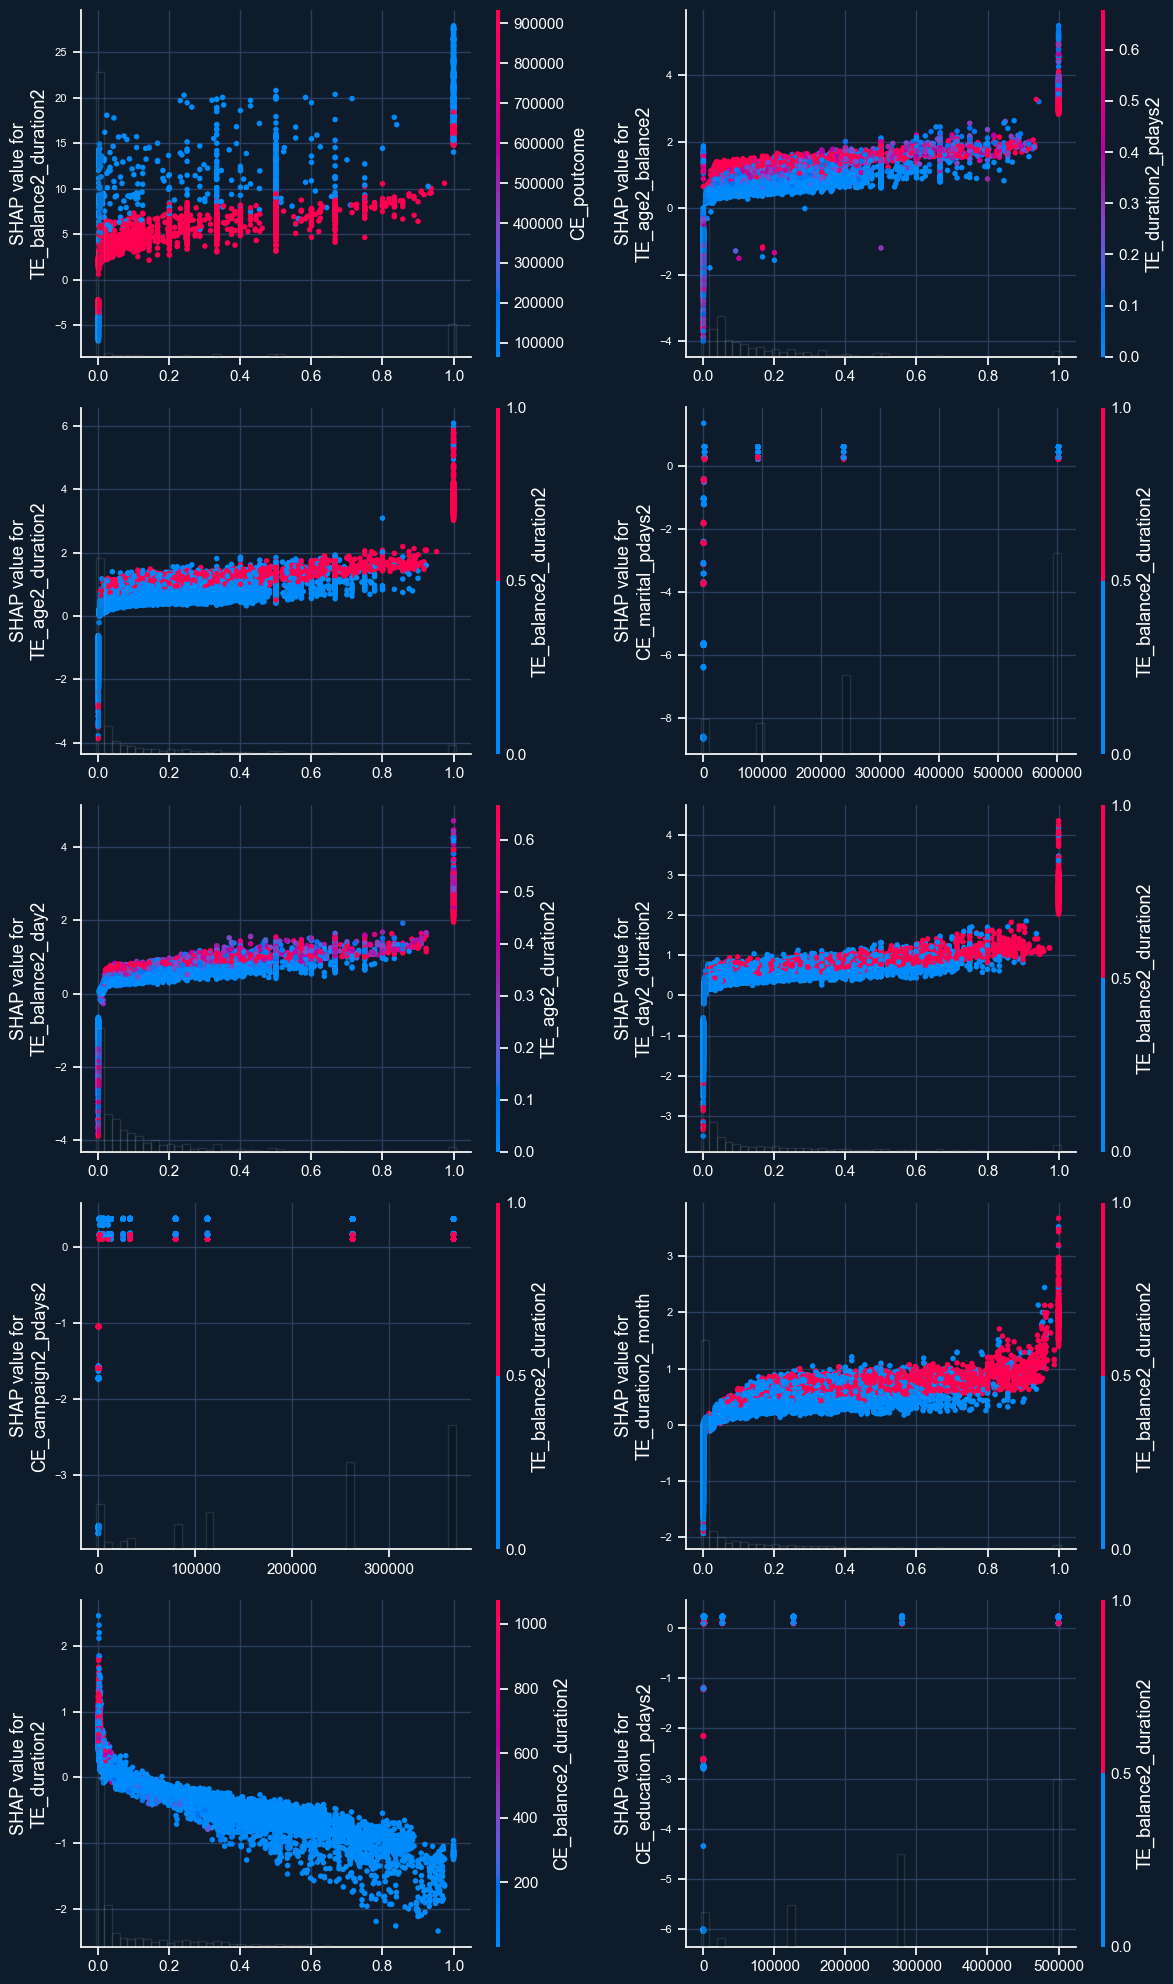

In [10]:
df_features = pd.DataFrame({
    "feature": sv.feature_names,
    "mean_abs_shap": np.mean(np.abs(sv.values), axis=0)
})
df_features = df_features.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

n = 10
topk = df_features["feature"].tolist()[:n]

ncols = 2
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
axes = axes.flatten()

for i, feat in enumerate(topk):
    ax = axes[i]
    shap.plots.scatter(sv[:, feat], color=sv, ax=ax, title=None, show=False)
    ax.set_xlabel(None)
    ax.title.set_color('white')
    #ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

The SHAP dependence plots confirm the dominant role of our engineered interaction features. For most of the top variables, we see a clear non-linear relationship with the prediction, where higher feature values push the model strongly toward the positive class.

The clearest example is again *TE_balance2_duration2*, where large values consistently generate high positive SHAP contributions. This reinforces the idea that clients with higher balances and longer call durations are much more likely to be classified as positives. Similar monotonic patterns appear with *TE_age2_balance2*, *TE_age2_duration2*, and *TE_balance2_day2*, showing that combinations of demographic information and financial or campaign activity are especially predictive.

Some features also reveal threshold effects. For instance, *CE_campaign2_pdays2* and *CE_marital_pdays2* remain relatively flat until a certain point, after which SHAP values spike sharply. This suggests that the model has learned cutoffs in the interaction between campaign history and personal attributes.

Overall, these plots highlight two important points. First, the most predictive features are not raw variables but engineered interactions, which capture relationships that simple features miss. Second, the model uses these interactions in a highly non-linear way, where only extreme or combined values push predictions strongly, while mid-range values have smaller effects.

Loaded SHAP explanations for 25000 samples and 415 features.


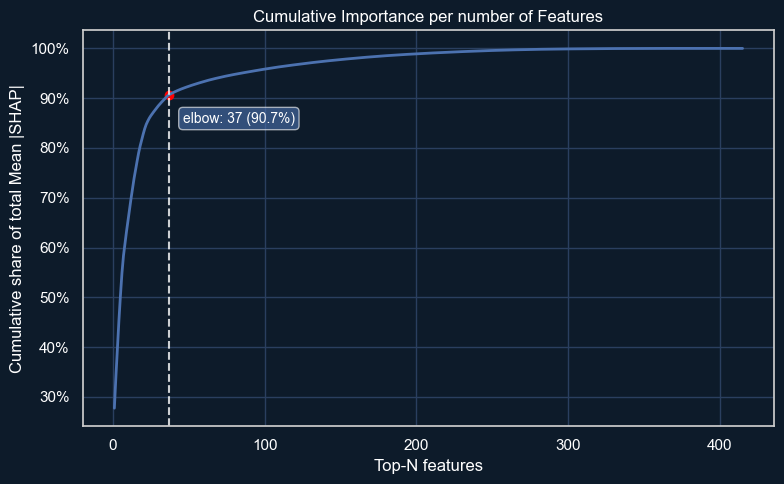

— Importance Concentration —
Top-10 features explain 65.5% of total Mean |SHAP|.
Top-20 features explain 82.8% of total Mean |SHAP|.
5 features suffice to cover 50% of total importance; 18 features for 80%.


In [11]:
shap_df = pd.DataFrame(sv.values , columns=sv.feature_names)

print(f"Loaded SHAP explanations for {shap_df.shape[0]} samples and {shap_df.shape[1]} features.")

# Global importances (row-augmented)
imp_df = shap_df.abs().mean(axis=0).sort_values(ascending=False)
plot_cumulative_importance(imp_df, title="Cumulative Importance per number of Features")

# Compute narrative KPIs
total_importance = float(imp_df.sum())
top10_share = float(imp_df.head(10).sum() / total_importance) if total_importance > 0 else 0.0
top20_share = float(imp_df.head(20).sum() / total_importance) if total_importance > 0 else 0.0

# Minimal N for 50% and 80% coverage
cum = imp_df.cumsum() / total_importance
n50 = int((cum <= 0.50).sum()) + 1 
n80 = int((cum <= 0.80).sum()) + 1 

print("— Importance Concentration —")
print(f"Top-10 features explain {top10_share:.1%} of total Mean |SHAP|.")
print(f"Top-20 features explain {top20_share:.1%} of total Mean |SHAP|.")
print(f"{n50} features suffice to cover 50% of total importance; {n80} features for 80%.")

The cumulative SHAP importance curve shows that predictive power is highly concentrated in a small subset of features. The top 5 features alone account for about 50% of the model’s total importance, and with only 18 features we already explain more than 80%. By the time we reach 37 features, we capture over 90% of the importance, after which the curve flattens almost completely.

This pattern confirms what we saw earlier: while we generated hundreds of engineered variables, the model relies heavily on a relatively small group of them. The remaining features add only marginal contributions, which suggests that most of the predictive lift comes from carefully designed interactions (especially balance, duration, age, and campaign history).

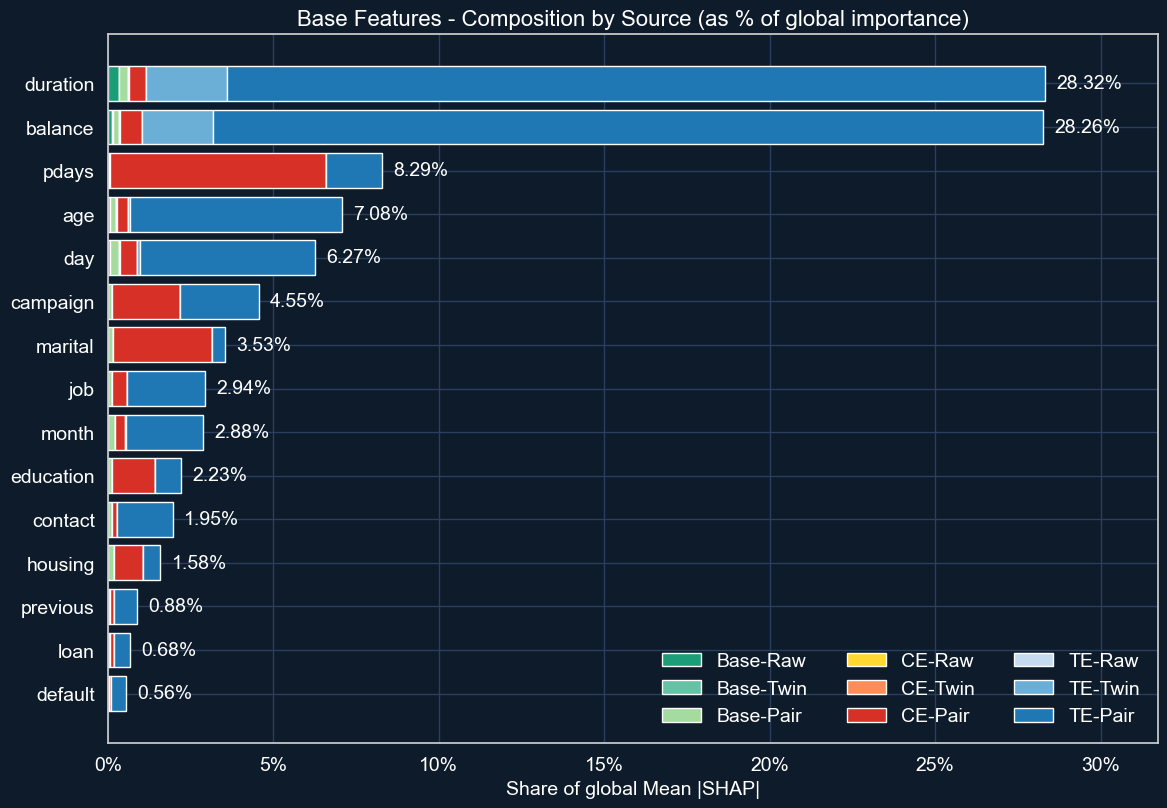

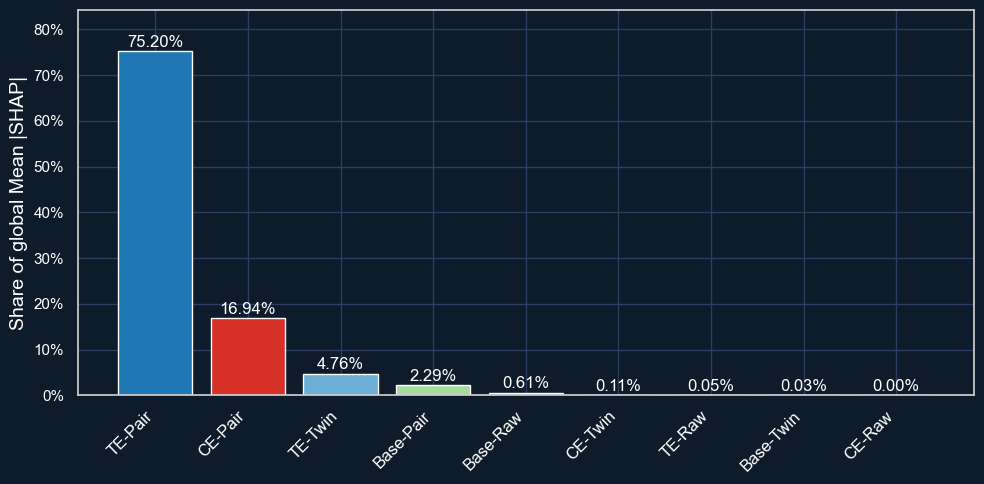

In [12]:
prefixes = ("TE_ORIG_", "TE_", "CE_")
stack_pct, totals_pct, labels = compute_percentage(df = imp_df, prefixes = prefixes)
plot_per_splits(totals = totals_pct, stack = stack_pct, labels = labels)
plot_aggregate(df = imp_df, prefixes = prefixes)

We then went back to the base raw features that were used to create all of our engineered features, to better understand where their importance actually comes from. In the chart above, we decompose the global SHAP importance of each base feature by the type of transformation applied. Here, CE refers to Count Encoding, while TE refers to Out-of-Folds Target Encoding.

The picture is very clear: the two strongest raw variables are duration and balance, which together account for more than 56% of the overall importance. Most of their contribution comes through target-encoded pairwise interactions (TE-Pair), showing that they gain predictive power not only individually but especially when combined with other variables.

Other features like pdays, age, and day also rank highly, with a large share of their contribution again coming from target-encoded or count-encoded combinations. In contrast, some raw variables such as loan, default, or previous barely contribute in their raw form and only add marginal value through interactions.

When we aggregate feature importance by “family” of transformations, the result is striking. Target-encoded pairwise interactions (TE-Pair) dominate overwhelmingly, accounting for more than 75% of the global importance. This confirms that combining two base variables and encoding them with out-of-fold target statistics was by far the most powerful strategy in our feature engineering pipeline.

The second-largest contribution comes from count-encoded pairwise features (CE-Pair) at around 17%, which shows that even simpler encodings of interactions were still meaningful. Beyond that, the impact drops sharply: TE-Twin features explain less than 5%, and everything else (raw, single encodings, or base pairs) barely adds up to a few percentage points combined.

This analysis highlights two key insights. First, interactions between variables matter much more than the variables in isolation — the model relies heavily on pairwise relationships rather than single raw attributes. Second, target encoding, applied carefully with out-of-fold estimation to avoid leakage, is what truly unlocked the predictive signal hidden in these interactions.

### 4.4 Conclusion

Across models and validation folds, feature engineering, notably target-encoded and count-encoded pairwise interactions with categorical *twins/pairs*, consistently delivered the largest AUC gains, while row-level augmentation was marginal. Performance generalized cleanly to the held-out test/leaderboard, indicating limited overfitting. SHAP analyses showed a steep importance concentration: a small subset of interaction features, for example combinations built on duration, balance, age, pdays, and campaign history, explains most of the lift, with rapidly diminishing returns beyond the top features. Base learners were highly rank-correlated, so stacking and blending added modest but stable improvements by consolidating aligned signals. Finally, accuracy remained inflated by class imbalance, whereas precision-recall reflected the true trade-off, confirming that the observed AUC gains stem from genuinely better ranking rather than thresholding effects.